In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
#df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
df = pd.read_csv('data/2020-09-01_2024-09-01/aggregated/percent_return.csv')
clustered_df = pd.read_csv('data/Cluster_data/3Clusters(2020-09-01_2024-09-01).csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_3_companies = clustered_df['Cluster 3'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_3 = df[['date'] + [col for col in df.columns if col in cluster_3_companies]]
df_cluster_3.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_3.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_3.to_csv("data\cluster_3")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

date
1
ABBV
2
ABT
3
ACN
4
ADI
5
ADM
6
ADP
7
AEE
8
AEP
9
AES
10
AFL
11
AIG
12
AIZ
13
AJG
14
ALL
15
ALLE
16
AMCR
17
AMGN
18
AMP
19
AMT
20
AOS
21
APD
22
ARE
23
ATO
24
AVB
25
AVGO
26
AVY
27
AWK
28
AXP
29
BAC
30
BAX
31
BBY
32
BDX
33
BEN
34
BG
35
BK
36
BKR
37
BLK
38
BMY
39
BR
40
BX
41
BXP
42
C
43
CAG
44
CAH
45
CAT
46
CB
47
CCI
48
CE
49
CFG
50
CHRW
51
CINF
52
CL
53
CLX
54
CMCSA
55
CME
56
CMI
57
CMS
58
CNP
59
COF
60
COP
61
COST
62
CPB
63
CPT
64
CSCO
65
CSX
66
CTAS
67
CTRA
68
CTSH
69
CVS
70
CVX
71
D
72
DD
73
DELL
74
DFS
75
DGX
76
DLR
77
DOC
78
DOV
79
DOW
80
DRI
81
DTE
82
DUK
83
DVN
84
EBAY
85
ECL
86
ED
87
EG
88
EIX
89
EMN
90
EMR
91
EOG
92
EQIX
93
EQR
94
ERIE
95
ES
96
ESS
97
ETN
98
ETR
99
EVRG
100
EXC
101
EXR
102
F
103
FANG
104
FAST
105
FDX
106
FE
107
FIS
108
FITB
109
FMC
110
FRT
111
GD
112
GEN
113
GILD
114
GIS
115
GLW
116
GPC
117
GRMN
118
GS
119
GWW
120
HAS
121
HBAN
122
HD
123
HIG
124
HII
125
HON
126
HPE
127
HPQ
128
HRL
129
HST
130
HSY
131
HUBB
132
IBM
133
ICE
134
IEX
135
IFF
136
INTC
137
INVH


In [30]:
df.shape

(1006, 492)

In [31]:
# Identify companies in Cluster 1 not found in df
missing_companies = [company for company in cluster_3_companies if company not in df.columns]
print(f"Companies in Cluster 1 not found in df: {missing_companies}")
print(f"Number of companies in Cluster 1: {len(cluster_3_companies)}")
print(f"Number of matched companies: {len(cluster_3_companies) - len(missing_companies)}")


Companies in Cluster 1 not found in df: []
Number of companies in Cluster 1: 273
Number of matched companies: 273


In [32]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_3), 5):
    if i + 4 >= len(df_cluster_3):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_3.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_3.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 9, 'max_depth': 6, 'max_delta_step': 6, 'learning_rate': 0.02, 'lambda': 1, 'gamma': 6, 'alpha': 1}
Best R^2 Score: 0.8897102313079414


In [34]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [35]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.88599557 0.88892019 0.89126259 0.88941644 0.89295637]
Mean CV R^2 Score: 0.8897102313079414
Test R^2 Score: 0.8869892420949228
Baseline R^2 Score: -3.511197683581102e-05


In [36]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.520839986943963
Baseline RMSE: 4.524090180889142
Model Improvement: 3.003250193945179


In [37]:
from sklearn.metrics import mean_squared_error

# Calculate RMSEp
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(predictions).std()
print(f"Daily Change Std Dev: {daily_changes}")

# Residuals (errors for each prediction)
residuals = y_test - predictions
print(f"Residuals Std. Dev: {np.std(residuals)}")

Model RMSE: 1.52
Baseline RMSE: 4.52
Model Improvement: 3.00
Daily Change Std Dev: 6.040727615356445
Residuals Std. Dev: 1.520695357735677


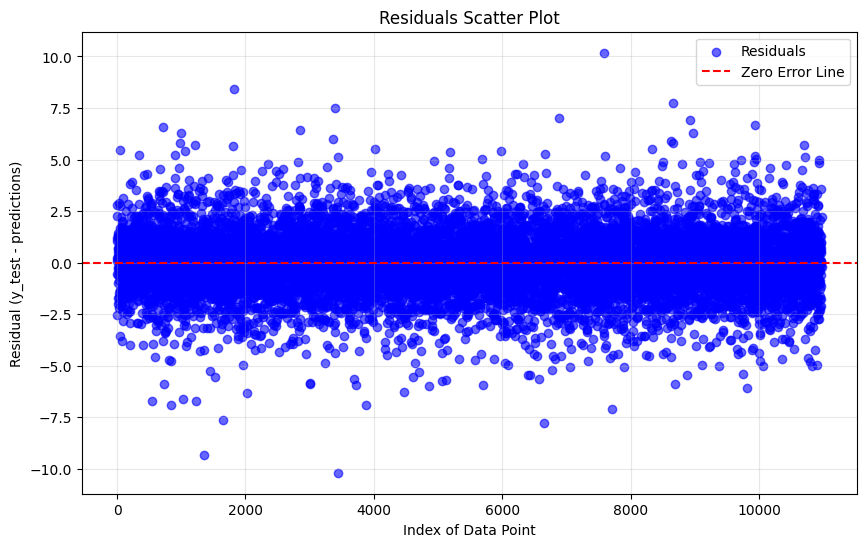

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


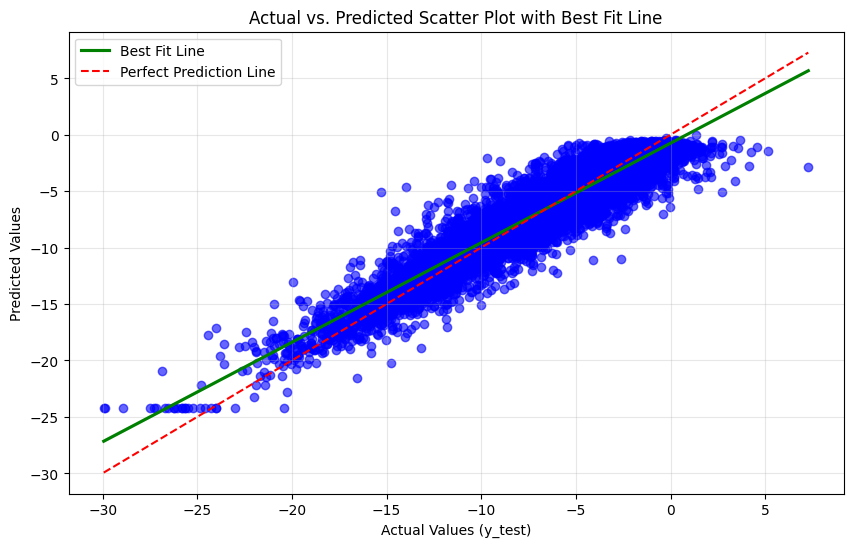

In [39]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

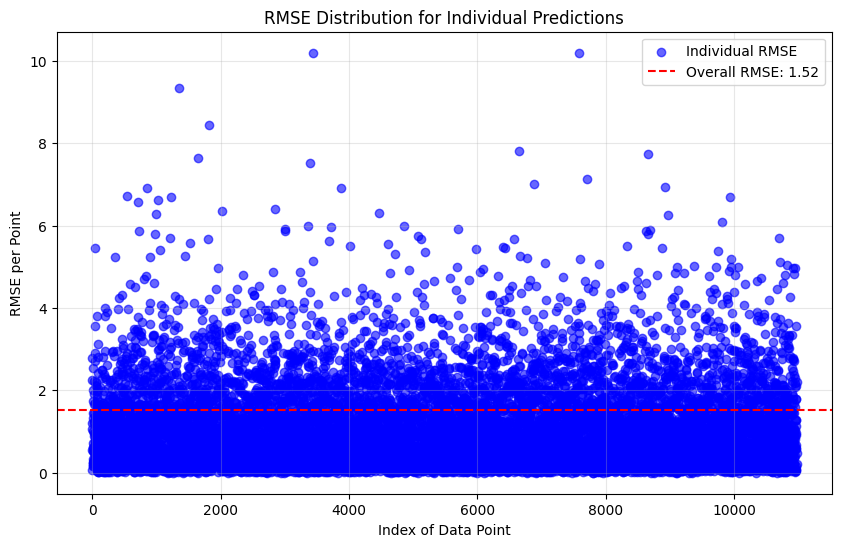

In [40]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
